In [ ]:
# ======================
# Preprocesamiento de datos para el dataset 'startup-success-prediction'
# ======================

!pip install kagglehub --quiet

import os
import pandas as pd
import numpy as np
import kagglehub
from sklearn.preprocessing import StandardScaler

# ======================
# 1. Descarga y carga del dataset original
# ======================
path = kagglehub.dataset_download("manishkc06/startup-success-prediction")
csv_path = os.path.join(path, "startup data.csv")
df = pd.read_csv(csv_path)

# ======================
# 2. Limpieza inicial de columnas irrelevantes
# ======================
initial_drop = [
    'Unnamed: 0', 'Unnamed: 6', 'state_code.1', 'id', 'object_id', 'name'
]
df.drop(columns=[c for c in initial_drop if c in df.columns], inplace=True)

# ======================
# 3. Conversión de columnas de fecha
# ======================
for c in ['founded_at', 'closed_at', 'first_funding_at', 'last_funding_at']:
    df[c] = pd.to_datetime(df[c], errors='coerce')

# ======================
# 4. Asegurar existencia de la columna 'status'
# ======================
if 'status' not in df.columns:
    raw = pd.read_csv(csv_path, usecols=['status'])
    df['status'] = raw['status']

# ======================
# 5. Creación de variables temporales derivadas
# ======================
fecha_corte = pd.to_datetime("2025-01-01")
df['lifetime_years'] = ((df['closed_at'].fillna(fecha_corte) - df['founded_at']).dt.days / 365).round(2)
df['funding_delay_years'] = ((df['first_funding_at'] - df['founded_at']).dt.days / 365).round(2)
df['last_milestone_delay_years'] = ((df['last_funding_at'] - df['founded_at']).dt.days / 365).round(2)
df['post_funding_duration_years'] = ((df['closed_at'].fillna(fecha_corte) - df['last_funding_at']).dt.days / 365).round(2)

# ======================
# 6. Eliminación de observaciones con errores temporales
# ======================
mask = (
    (df['lifetime_years'] < 0) |
    (df['funding_delay_years'] < 0) |
    (df['last_milestone_delay_years'] < 0) |
    (df['post_funding_duration_years'] < 0) |
    (df.get('age_first_funding_year', 0) < 0) |
    (df.get('age_last_funding_year', 0) < 0) |
    (df.get('age_first_milestone_year', 0) < 0) |
    (df.get('age_last_milestone_year', 0) < 0)
)
df = df.loc[~mask].copy()

# ======================
# 7. Clasificación sector y agrupación de ciudades
# ======================
tech = {'software', 'web', 'mobile', 'enterprise'}
df['main_sector'] = df['category_code'].apply(lambda x: 'tech' if x in tech else 'non_tech')

top = df['city'].value_counts()
freq = top[top > 20].index
df['city_grouped'] = df['city'].apply(lambda x: x if x in freq else 'other')

# ======================
# 8. Escalado de variables numéricas
# ======================
scaler = StandardScaler()
for col in ['funding_total_usd', 'relationships', 'avg_participants']:
    if col in df.columns:
        df[f"{col}_scaled"] = scaler.fit_transform(df[[col]])

# ======================
# 9. Variables booleanas derivadas
# ======================
df['has_milestones'] = df['milestones'] > 0
df['has_late_funding'] = (df.get('has_roundC', 0) == 1) | (df.get('has_roundD', 0) == 1)

# ======================
# 10. Eliminación de columnas redundantes
# ======================
derived_drop = [
    'city', 'category_code', 'founded_at', 'closed_at', 'first_funding_at', 'last_funding_at',
    'milestones', 'has_roundA', 'has_roundB', 'has_roundC', 'has_roundD',
    'funding_total_usd', 'relationships', 'avg_participants'
]

extra_drop = [
    'age_first_funding_year', 'age_last_funding_year',
    'age_first_milestone_year', 'age_last_milestone_year',
    'state_code', 'zip_code', 'latitude', 'longitude',
    'has_milestone_info', 'status', 'is_top500'
]

drop_all = derived_drop + extra_drop + [c for c in df.columns if c.startswith('is_')]
df.drop(columns=[c for c in drop_all if c in df.columns], inplace=True)

# ======================
# 11. Separación de variable objetivo
# ======================
X = df.drop(columns='labels')
y= df['labels'].astype(int).values

# ======================
# 12. Resultado final
# ======================
print("Columnas finales disponibles para modelado:", X.columns.tolist())
print("Número de muestras:", X.shape[0])
     


[notice] A new release of pip is available: 24.3.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


Columnas finales disponibles para modelado: ['funding_rounds', 'has_VC', 'has_angel', 'lifetime_years', 'funding_delay_years', 'last_milestone_delay_years', 'post_funding_duration_years', 'main_sector', 'city_grouped', 'funding_total_usd_scaled', 'relationships_scaled', 'avg_participants_scaled', 'has_milestones', 'has_late_funding']
Número de muestras: 825


In [35]:

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.metrics import classification_report
from scikeras.wrappers import KerasClassifier
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.optimizers import Adam

# ======================
# 1. División del dataset
# ======================
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    stratify=y,
    random_state=42
)

# ======================
# 2. Columnas categóricas y numéricas
# ======================
cat_cols = X.select_dtypes(include=['object', 'bool', 'category']).columns.tolist()
num_cols = [
    c for c in X.select_dtypes(include=['int64', 'float64']).columns
    if not c.endswith('_scaled')
]

# ======================
# 3. Preprocesador
# ======================
preprocessor = ColumnTransformer([
    ('ohe',    OneHotEncoder(handle_unknown='ignore', sparse_output=False, drop='if_binary'), cat_cols),
    ('scaler', StandardScaler(), num_cols)
], remainder='drop')

# ======================
# 4. Definición de la red neuronal
# ======================
def build_model(input_shape):
    input_layer = Input(shape=(input_shape,))
    x = Dense(32, activation='relu')(input_layer)
    x = Dense(16, activation='relu')(x)
    output_layer = Dense(1, activation='sigmoid')(x)
    
    model = Model(inputs=input_layer, outputs=output_layer)
    model.compile(optimizer=Adam(), loss='binary_crossentropy', metrics=['accuracy'])
    return model

# ======================
# 5. Ajuste previo del preprocesador para determinar input_shape
# ======================
X_train_processed = preprocessor.fit_transform(X_train)
input_shape = X_train_processed.shape[1]

# ======================
# 6. KerasClassifier
# ======================
model_mlp = KerasClassifier(
    model=build_model,
    model__input_shape=input_shape,
    epochs=20,
    batch_size=32,
    verbose=1,
    validation_split=0.1
)

# ======================
# 7. Pipeline completo
# ======================
pipe = Pipeline([
    ('prep', preprocessor),
    ('mlp', model_mlp)
])

# ======================
# 8. Validación cruzada con GridSearchCV
# ======================
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
param_grid = {
    'mlp__epochs': [10, 15, 20],
    'mlp__batch_size': [16, 25,  32]
}
grid = GridSearchCV(
    estimator=pipe,
    param_grid=param_grid,
    cv=cv,                        
    scoring='accuracy',          
    n_jobs=-1,                   
    verbose=2
)

grid.fit(X_train, y_train)
print("Mejores hiperparámetros:", grid.best_params_)
print("Mejor score de validación cruzada:", grid.best_score_)

# Usar el mejor modelo directamente
best_model = grid.best_estimator_

# ======================
# 9. Evaluación
# ======================
y_pred = best_model.predict(X_test)
print(classification_report(y_test, y_pred))



Fitting 5 folds for each of 9 candidates, totalling 45 fits
Epoch 1/15
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.8322 - loss: 0.5530 - val_accuracy: 0.9697 - val_loss: 0.3620
Epoch 2/15
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9765 - loss: 0.3114 - val_accuracy: 0.9848 - val_loss: 0.1773
Epoch 3/15
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9841 - loss: 0.1586 - val_accuracy: 1.0000 - val_loss: 0.0762
Epoch 4/15
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9917 - loss: 0.0728 - val_accuracy: 1.0000 - val_loss: 0.0383
Epoch 5/15
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9874 - loss: 0.0669 - val_accuracy: 1.0000 - val_loss: 0.0242
Epoch 6/15
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9904 - loss: 0.0487 - val_accuracy: 1.0000 - val_loss: 0.0177
Epoch 7/15
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9946 - loss: 0.0314 - val_accuracy: 1.0000 - val_loss: 0.0140
Epoch 8/15
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accura

In [36]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Input

import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import seaborn as sns
import shap

In [37]:
#CLASSIFICATION REPORT DEL CONJUNTO TEST DEL MODELO 
from sklearn.metrics import classification_report
#Transformamos la salida probabilistica de nuestra red en una variable binaria 
y_pred = pd.Series(y_pred.flatten()).apply(lambda x: 1 if x >= 0.5 else 0)
#Devolvemos el clasification report
print(classification_report(y_test, y_pred))


              precision    recall  f1-score   support

           0       0.96      1.00      0.98        55
           1       1.00      0.98      0.99       110

    accuracy                           0.99       165
   macro avg       0.98      0.99      0.99       165
weighted avg       0.99      0.99      0.99       165



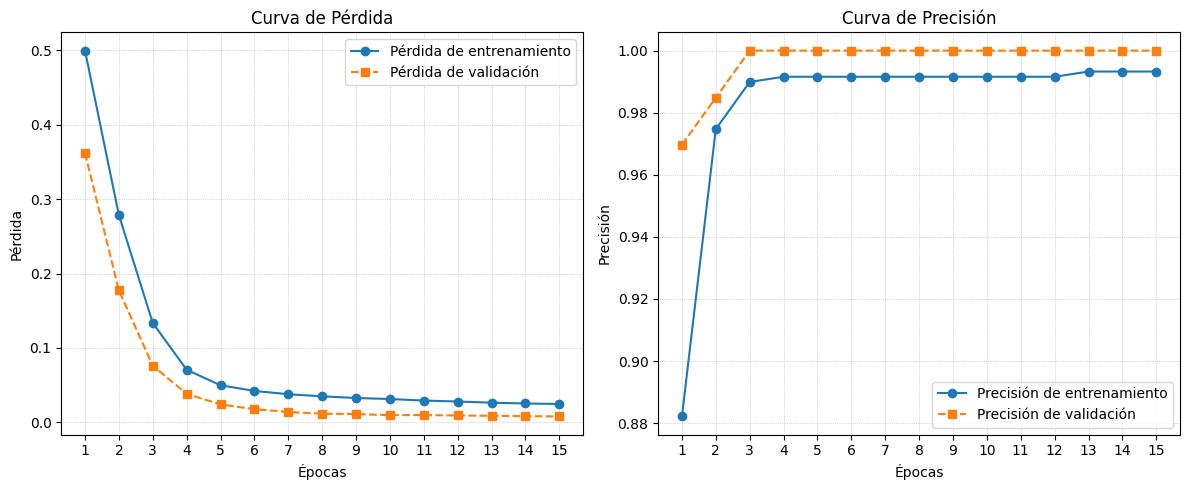

In [40]:
#Gráficos de perdida y presición 

#En la variable metricas guardamos el diccionario que tiene estos parametros almacenados
metricas=best_model.named_steps['mlp'].history_

#Definimos el numero de epochs como la longuitud de las metricas 
epochs = np.arange(1, len(metricas['loss']) + 1)

#Tamaño  del gráfico
plt.figure(figsize=(12, 5))

# Curva de pérdida
plt.subplot(1, 2, 1)
#Perdida conjunto de  datos train
plt.plot(epochs, metricas['loss'], marker='o', linestyle='-', label='Pérdida de entrenamiento')
#Perdida conjunto de datos validacion (10% de los datos train)
plt.plot(epochs, metricas['val_loss'],marker='s', linestyle='--', label='Pérdida de validación')
#Títulos y etiquetas
plt.title('Curva de Pérdida')
plt.xlabel('Épocas')
plt.ylabel('Pérdida')
plt.xticks(epochs)                     
plt.grid(True, linestyle=':', linewidth=0.5)
plt.legend()

# Curva de precisión
plt.subplot(1, 2, 2)
#Precisión del conjunto de datos train 
plt.plot(epochs, metricas['accuracy'],marker='o', linestyle='-',label='Precisión de entrenamiento')
#Precisión del conjunto de datos validacion (10% de los datos train)
plt.plot(epochs, metricas['val_accuracy'],marker='s', linestyle='--', label='Precisión de validación')
#Títulos y etiquetas
plt.title('Curva de Precisión')
plt.xlabel('Épocas')
plt.ylabel('Precisión')
plt.xticks(epochs)                       
plt.grid(True, linestyle=':', linewidth=0.5)
plt.legend()

plt.tight_layout()
plt.show()


42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 857us/step


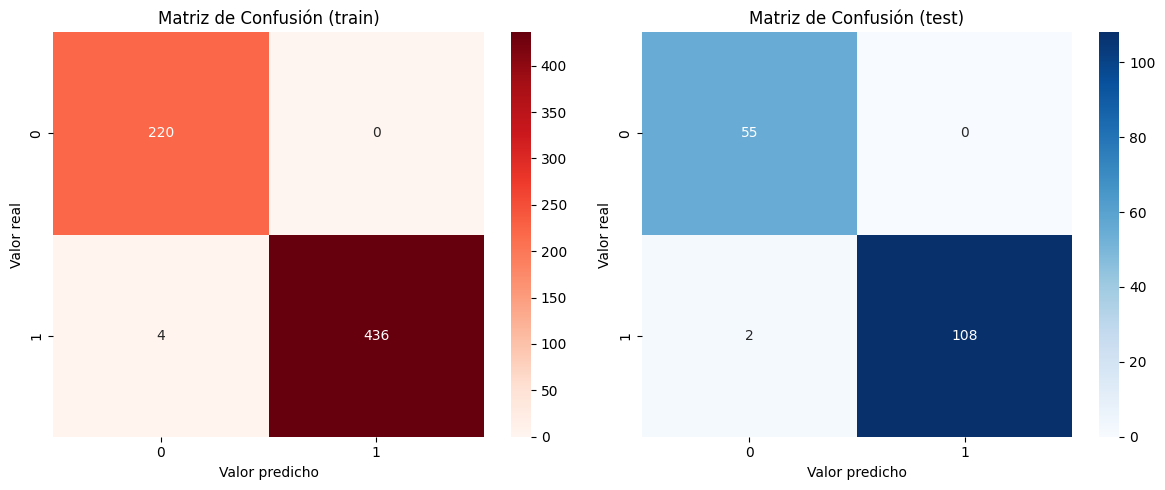

In [41]:
#Matriz de confunsión 

#Conjunto train 
y_pred_t=best_model.predict(X_train)
y_pred_t=pd.Series(y_pred_t.flatten()).apply(lambda x: 1 if x >= 0.5 else 0)
labels=[0,1]
#Matriz de confusión
cm_train=confusion_matrix(y_train,y_pred_t)
#Headmap 
plt.figure(figsize=(12, 5))
plt.subplot(1,2,1)
sns.heatmap(cm_train, annot=True, fmt="d", cmap="Reds")
plt.xlabel("Valor predicho")
plt.ylabel("Valor real")
plt.title("Matriz de Confusión (train)")

#Conjunto test
#Matriz de confusión
cm_test=confusion_matrix(y_test,y_pred)
#headmap
plt.subplot(1,2,2)
sns.heatmap(cm_test, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Valor predicho")
plt.ylabel("Valor real")
plt.title("Matriz de Confusión (test)")

plt.tight_layout()
plt.show()

### Calculo de los valores SHAP
He tratado de eliminar los warnings, que al parecer son por temas de estructura, pero no consigo eliminarlos. Queda pendiente ver la forma de eliminarlos o aclarar si tienen o no impacto en la salida que parece que no lo tienen.

c:\Users\rauls\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\models\functional.py:238: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: keras_tensor_12
Received: inputs=['Tensor(shape=(165, 19))']
  warnings.warn(msg)
c:\Users\rauls\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\models\functional.py:238: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: keras_tensor_12
Received: inputs=['Tensor(shape=(50, 19))']
  warnings.warn(msg)


Index(['funding_rounds', 'has_VC', 'has_angel', 'lifetime_years',
       'funding_delay_years', 'last_milestone_delay_years',
       'post_funding_duration_years', 'main_sector', 'city_grouped',
       'funding_total_usd_scaled', 'relationships_scaled',
       'avg_participants_scaled', 'has_milestones', 'has_late_funding'],
      dtype='object')


C:\Users\rauls\AppData\Local\Temp\ipykernel_32108\1689747765.py:25: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(np.squeeze(shap_values), X_to_explain,feature_names=feature_names)


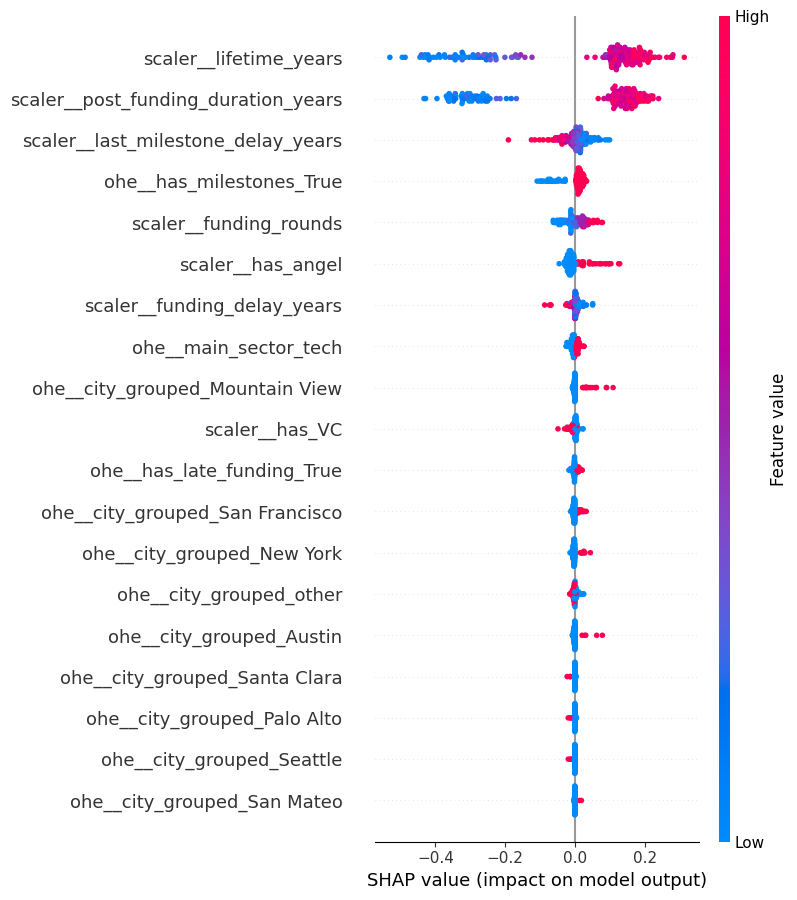

In [42]:
#CALCULO DE LOS VALORES SHAP 
import shap 
import tensorflow as tf

model = best_model.named_steps['mlp'].model_

#Realizamos el preprocesamiento sobre X_train y X_test
X_train_p=best_model.named_steps['prep'].transform(X_train)
X_test_p=best_model.named_steps['prep'].transform(X_test)

feature_names = best_model.named_steps['prep'].get_feature_names_out()

#Transformamos los dataset en numpy arrays 
X_background = X_train_p.values if isinstance(X_train_p, pd.DataFrame) else X_train_p
X_to_explain = X_test_p.values if isinstance(X_test_p, pd.DataFrame) else X_test_p

#Ejecutamos el metodo DeepExplainer pasandole el modelo y los datos train
explainer = shap.GradientExplainer(model, X_background)

#Calculamos los valores shap para el conjunto test
shap_values = explainer.shap_values(X_to_explain )
#Obtenemos el summary plot 

print(X_test.columns)
shap.summary_plot(np.squeeze(shap_values), X_to_explain,feature_names=feature_names)


#shap.summary_plot(np.squeeze(shap_values), X_to_explain_df, plot_type='bar', cmap='viridis')

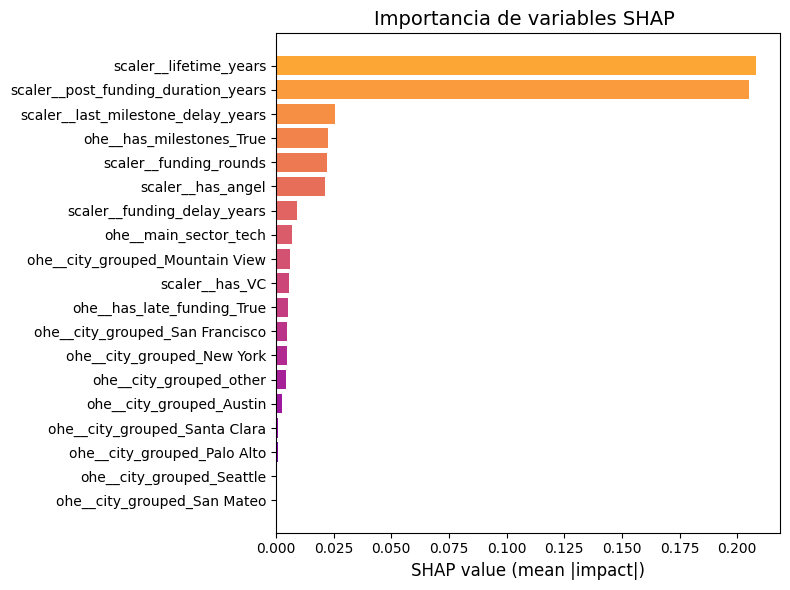

In [43]:
# Calcular importancia media absoluta por feature
shap_importance = np.abs(np.squeeze(shap_values)).mean(axis=0)
#Definimos un DF con las medias de los valores shap para cada variable para facilitar la modificacion de los gráficos
shap_df = pd.DataFrame({
    'feature': feature_names,
    'importance': shap_importance
}).sort_values(by='importance', ascending=True)

# Graficar
plt.figure(figsize=(8, 6))
plt.barh(shap_df['feature'], shap_df['importance'], color=plt.cm.plasma(np.linspace(0.2, 0.8, len(shap_df))))
plt.xlabel("SHAP value (mean |impact|)", fontsize=12)
plt.title("Importancia de variables SHAP ", fontsize=14)
plt.tight_layout()
plt.show()

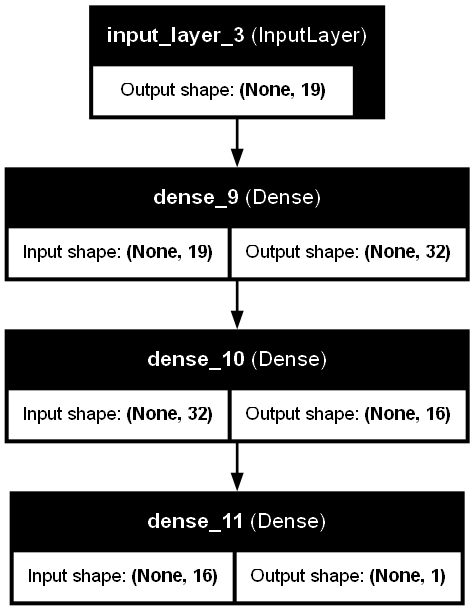

In [44]:
from tensorflow.keras.utils import plot_model  # o from keras.utils.vis_utils import plot_model

# 'model' es tu instancia de tf.keras.Model o keras.Model
plot_model(
    model,
    to_file="model_plot.png",    # Nombre del archivo de salida
    show_shapes=True,            # Muestra los tamaños de tensor en cada capa
    show_dtype=False,            # Muestra los tipos de dato de tensor
    show_layer_names=True,       # Muestra el nombre de cada capa
    rankdir="TB",                # 'TB' (top→bottom) o 'LR' (left→right)
    expand_nested=False,         # Despliega submodelos anidados
    dpi=96                       # Resolución de la imagen
)